In [1]:
!pip install -q -U bitsandbytes transformers peft accelerate trl datasets sentencepiece wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 87.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 75.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:0

In [53]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig
import torch
import os
from tqdm import tqdm
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, display_html

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from datasets import load_dataset, Dataset
from trl import SFTTrainer, SFTConfig

In [3]:
os.environ['HF_TOKEN'] = ""

In [4]:
QUANTIZE_4BIT = True
USE_GRAD_CHECKPOINTING = True
TRAIN_BATCH_SIZE = 4
TRAIN_MAX_SEQ_LENGTH = 512
USE_FLASH_ATTENTION = False
GRAD_ACC_STEPS = 16

In [5]:
MODEL_NAME = "CohereForAI/aya-expanse-8b"

quantization_config = None
if QUANTIZE_4BIT:
  quantization_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_use_double_quant=True,
      bnb_4bit_compute_dtype=torch.bfloat16,
  )

attn_implementation = None
if USE_FLASH_ATTENTION:
  attn_implementation="flash_attention_2"

model = AutoModelForCausalLM.from_pretrained(
          MODEL_NAME,
          quantization_config=quantization_config,
          attn_implementation=attn_implementation,
          torch_dtype=torch.float16,
          device_map="auto"
        )

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/8.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

In [6]:
DATASET_URL = "https://raw.githubusercontent.com/persiannlp/parsinlu/master/data/sentiment-analysis/food.jsonl"
LABEL_MAP = {
    "3": "سایر",
    "2": "مثبت",
    "1": "مثبت",
    "0": "خنثی",
    "-1": "منفی",
    "-2": "منفی"
}
TEST_COUNT = 190
RANDOM_STATE = 18

In [7]:
dataset = load_dataset("json", data_files=DATASET_URL)
df = dataset['train'].to_pandas()
df = df[['review', 'sentiment']]
df['sentiment'] = df['sentiment'].map(LABEL_MAP)

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
sub_df = df.sample(n=TEST_COUNT, random_state=RANDOM_STATE)
diff_df = df.loc[~df.index.isin(sub_df.index)]

In [9]:
system_prompt_01 = """
تو یک دستیار هوشمند برای تحلیل احساسات هستی.
یک نظر کوتاه درباره ی غذا به زبان فارسی دریافت میکنی.
وظیفه‌ی تو این است که احساس کلی نظر را در یکی از چهار دسته‌ی زیر طبقه‌بندی کنی:

- مثبت
- منفی
- خنثی
- سایر

فقط یکی از این چهار برچسب را برگردان. هیچ متن اضافی، توضیح، یا عبارتی مانند «احساس:» در پاسخ ننویس.
اگر احساس نظر نامشخص، متناقض یا ترکیبی بود، فقط برچسب «سایر» را برگردان
"""

In [10]:
zs_user_prompt_01= """
نظر: REVIEW
احساس:
"""

In [11]:
dataset = Dataset.from_pandas(diff_df)

In [12]:
def formatting_prompts_func(dataset):
    system_text = system_prompt_01
    combined_text = (
    f"<|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|>{system_text}<|END_OF_TURN_TOKEN|>"
    f"<|START_OF_TURN_TOKEN|><|USER_TOKEN|>{dataset['review']}<|END_OF_TURN_TOKEN|>"
    f"<|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>{dataset['sentiment']}<|END_OF_TURN_TOKEN|>"
    )
    return combined_text

In [13]:
def format_to_conversational(example):
    return {
        "messages": [
            {"role": "system", "content": system_prompt_01},
            {"role": "user", "content": example["review"]},
            {"role": "assistant", "content": example["sentiment"]}
        ]
    }

In [14]:
dataset = dataset.map(format_to_conversational)

Map:   0%|          | 0/1727 [00:00<?, ? examples/s]

In [15]:
split = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split["train"]
val_dataset = split["test"]

In [16]:
template = {'default': "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{% set loop_messages = messages[1:] %}{% set system_message = messages[0]['content'] %}{% elif false == true %}{% set loop_messages = messages %}{% set system_message = 'You are Aya, a brilliant, sophisticated, multilingual AI-assistant trained to assist human users by providing thorough responses. You are able to interact and respond to questions in 23 languages and you are powered by a multilingual model built by Cohere For AI.' %}{% else %}{% set loop_messages = messages %}{% set system_message = false %}{% endif %}{% if system_message != false %}{{ '<|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|>' + system_message + '<|END_OF_TURN_TOKEN|>' }}{% endif %}{% for message in loop_messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<|START_OF_TURN_TOKEN|><|USER_TOKEN|>' + content.strip() + '<|END_OF_TURN_TOKEN|>' }}{% elif message['role'] == 'assistant' %}{% generation %}{{ '<|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>'  + content.strip() + '<|END_OF_TURN_TOKEN|>' }}{% endgeneration %}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>' }}{% endif %}"}
tokenizer.chat_template = template

In [17]:
# training_arguments = TrainingArguments(
#     output_dir="results",
#     num_train_epochs=20,
#     per_device_train_batch_size=TRAIN_BATCH_SIZE,
#     gradient_accumulation_steps=GRAD_ACC_STEPS,
#     gradient_checkpointing=USE_GRAD_CHECKPOINTING,
#     optim="paged_adamw_32bit",
#     save_steps=50,
#     logging_steps=10,
#     learning_rate=1e-3,
#     weight_decay=0.001,
#     fp16=False,
#     bf16=True,
#     warmup_ratio=0.05,
#     group_by_length=True,
#     lr_scheduler_type="constant",
#     report_to="none"
# )

sft_config = SFTConfig(
    output_dir="results",
    num_train_epochs=3,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACC_STEPS,
    gradient_checkpointing=USE_GRAD_CHECKPOINTING,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=10,
    learning_rate=1e-3,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    warmup_ratio=0.05,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="none",
    assistant_only_loss=True,
    dataset_text_field="text",
    max_length=TRAIN_MAX_SEQ_LENGTH
)

peft_config = LoraConfig(
    lora_alpha=32,
    r=32,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"]
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=sft_config
)

Tokenizing train dataset:   0%|          | 0/1381 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1381 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/346 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/346 [00:00<?, ? examples/s]

In [18]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.813200
20,0.085300
30,0.059900
40,0.065900
50,0.044000
60,0.035600


TrainOutput(global_step=66, training_loss=0.4730968238277869, metrics={'train_runtime': 4336.8196, 'train_samples_per_second': 0.955, 'train_steps_per_second': 0.015, 'total_flos': 3.258318185472e+16, 'train_loss': 0.4730968238277869})

In [19]:
trainer.model.save_pretrained(save_directory='aya-expanse-zs-fa-sentiment')
model.config.use_cache = True
model.eval()

CohereForCausalLM(
  (model): CohereModel(
    (embed_tokens): Embedding(256000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x CohereDecoderLayer(
        (self_attn): CohereAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=32, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=32, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
       

In [20]:
model_result = sub_df.copy()

In [30]:
def aya_run(df):
    df.loc[:, 'zs_fa'] = None

    total_steps = len(df)

    with tqdm(total=total_steps, desc="Processing") as pbar:
        for index, row in df.iterrows():
            prompt = format_to_conversational(row)['messages']
            input_ids = tokenizer.apply_chat_template(prompt,
                                              tokenize=True,
                                              add_generation_prompt=True,
                                              return_tensors="pt").to(model.device)

            gen_tokens = model.generate(
                input_ids,
                max_new_tokens=5,
                do_sample=False
                )
        
            generated = gen_tokens[0][input_ids.shape[-1]:]
            gen_text = tokenizer.decode(generated, skip_special_tokens=True)
            result = gen_text.strip()
            df.at[index, 'zs_fa'] = result
            pbar.update(1)

In [31]:
aya_run(model_result)

Processing: 100%|██████████| 190/190 [07:00<00:00,  2.21s/it]


In [32]:
model_result.to_csv('/kaggle/working/cohere_aya_8b_fine_tuned.csv')
model_result.head(20)

,review,sentiment,zs_fa
1634,فقط بدیه این محصول اینه که حد اکثر ۱۰ عدد میشه...,سایر,سایر
1891,نسبت به قیمت جدیدش قهوه های بهتری رو توی این ر...,منفی,منفی
858,قطر 1 این برندو جایی ندیدم.اتفاقا دنبالش بودم ...,مثبت,مثبت
684,رگ گیری که اصلا نشده بود و کار خیلی سختی بود ر...,منفی,منفی
446,طعم خیلی خوب بود و قیمتش درشگفت انگیز عالی بود,مثبت,مثبت
733,طعمش رو اصلا دوست نداشتم و تموم نشده هنوز که ر...,منفی,منفی
1057,بیسکوییت خوشمزه ای است و در تخفیف ویژه ارزش خر...,مثبت,مثبت
1391,پسته خوبیه. من چند تاش را تو شگفت انگیز گرفتم....,مثبت,مثبت
848,در شگفت انگیز خریدم هنوز استفاده نکردم ولی محص...,مثبت,مثبت
455,***کیفیت خوبی داره ولی قیمتش از بیرون گرون تر ...,سایر,سایر


In [33]:
map_sentiment = {
    'مثبت':'POSITIVE',
    'منفی':'NEGATIVE',
    'خنثی':'NEUTRAL',
    'سایر':'OTHER'
}

In [35]:
model_result['sentiment'] = model_result['sentiment'].map(map_sentiment)
model_result['zs_fa'] = model_result['zs_fa'].map(map_sentiment)

In [40]:
def plot_confusion_matrix(df):
    labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'OTHER']
    prediction_columns = list(['zs_fa'])

    num_preds = len(prediction_columns)
    cols = 2
    rows = (num_preds + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for i, pred_col in enumerate(prediction_columns):
        cm = confusion_matrix(df['sentiment'], df[pred_col], labels=labels)
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Confusion Matrix: {pred_col}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [51]:
def calculate_metrics(df):
    labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'OTHER']
    prediction_columns = list(['zs_fa'])

    results = {}

    for i, pred_col in enumerate(prediction_columns):
        report = classification_report(df['sentiment'], df[pred_col], labels=labels, output_dict=True, zero_division=0)

        report["accuracy"] = {
            "precision": accuracy_score(df['sentiment'], df[pred_col]),
            "recall": accuracy_score(df['sentiment'], df[pred_col]),
            "f1-score": accuracy_score(df['sentiment'], df[pred_col]),
            "support": len(df['sentiment'])
        }

        report_df = pd.DataFrame(report).transpose()
        report_df = report_df.round(3)
        results[pred_col] = report_df

    return results

In [38]:
def show_metrics_grid(df):
    metrics_dict = calculate_metrics(df)
    dfs = list(metrics_dict.values())
    titles = list(metrics_dict.keys())

    html_tables = [
        f"<div style='padding:10px'><h4 style='text-align:center'>Experiment: {title}</h4>{df.to_html()}</div>"
        for title, df in zip(titles, dfs)
    ]

    rows = [''.join(html_tables[::2]), ''.join(html_tables[1::2])]

    grid_html = '<table><tr><td>' + '</td><td>'.join(rows) + '</td></tr></table>'
    display_html(grid_html, raw=True)

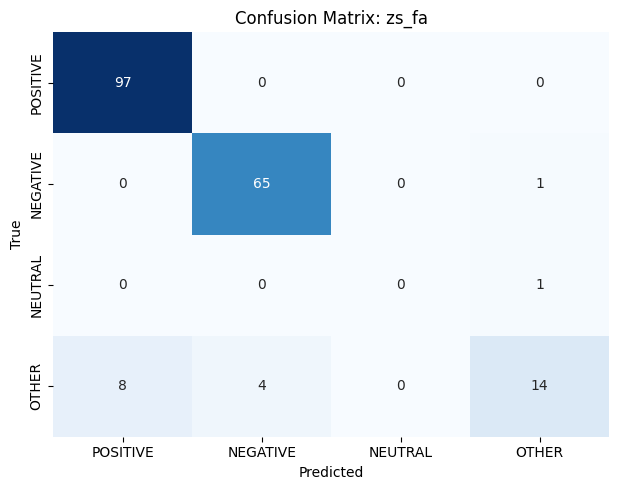

In [49]:
plot_confusion_matrix(model_result)

In [54]:
show_metrics_grid(model_result)

Experiment: zs_fa 
 
 
 
 precision 
 recall 
 f1-score 
 support 
 
 
 
 
 POSITIVE 
 0.924 
 1.000 
 0.960 
 97.0 
 
 
 NEGATIVE 
 0.942 
 0.985 
 0.963 
 66.0 
 
 
 NEUTRAL 
 0.000 
 0.000 
 0.000 
 1.0 
 
 
 OTHER 
 0.875 
 0.538 
 0.667 
 26.0 
 
 
 accuracy 
 0.926 
 0.926 
 0.926 
 190.0 
 
 
 macro avg 
 0.685 
 0.631 
 0.648 
 190.0 
 
 
 weighted avg 
 0.919 
 0.926 
 0.916 
 190.0